# **Upgrading Matplotlib Package**

Note : Run "!pip install matplotlib --upgrade matplotlib" and restart the runtime before importing the libraries. This is to upgrade the matplotlib package to the latest version so that the codes for the "Exploratory Data Analysis" Part will work.

In [ ]:
!pip install matplotlib --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.0 MB/s 
     |████████████████████████████████| 965 kB 52.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


# **Importing all the libraries**

In [ ]:
import matplotlib.pyplot as plt  
import keras  
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.python import metrics

from sklearn.metrics import classification_report,confusion_matrix

from PIL import Image
from warnings import filterwarnings


In [ ]:
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']

# **Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#We first start off by appending and resize all the images from the directories into a two separate lists,namely x and y. 

labels = ['glioma', 'notumor', 'meningioma', 'pituitary']

x = []
y= []
image_size = 224 # all the images will be resized into 150 by 150

for i in labels:
  folderPath = os.path.join('/content/drive/MyDrive/MRI Dataset Version 2 (7023 images)','Training',i)
  for j in tqdm(os.listdir(folderPath)):              #os.listdir will give us all the directories in the 'folderPath'
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    x.append(img)
    y.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI Dataset Version 2 (7023 images)','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x.append(img)
        y.append(i)

#Then, convert all the resized images and labels into numpy arrays.

x = np.array(x)    
y= np.array(y)   



100%|██████████| 300/300 [00:01<00:00, 196.20it/s]


# **Exploratory Data Analysis**

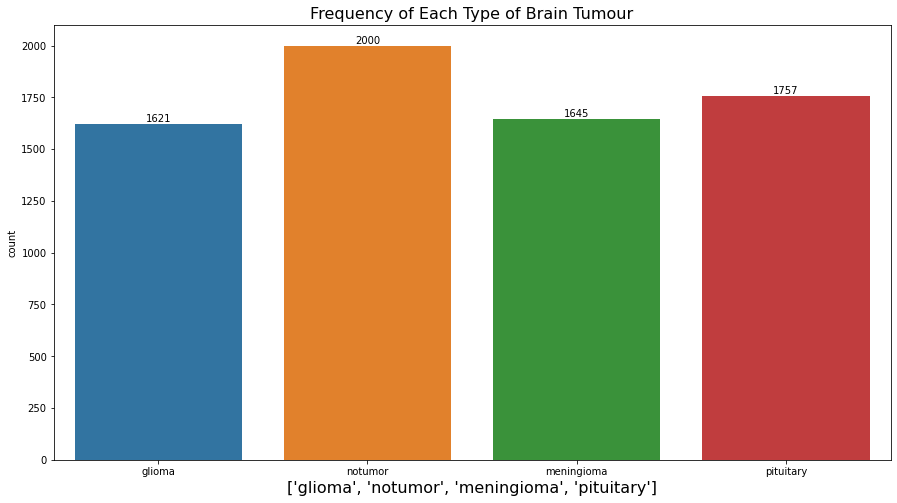

In [ ]:
#Display the number of images of each type of Brain Tumour
df = pd.DataFrame(y, columns=['labels'])

def freq_plot(column_name):
  plt.figure(figsize=(15,8))
  ax = sns.countplot(x="labels", data=df)
  plt.title("Frequency of Each Type of Brain Tumour", fontsize=16)
  plt.xlabel(f"{column_name}",fontsize=16)
  ax.bar_label(ax.containers[0], label_type='edge')
  plt.show()

freq_plot(labels)

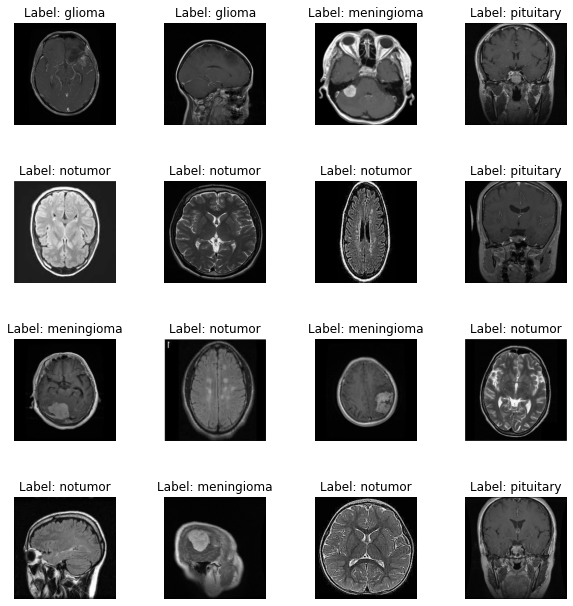

In [ ]:
#Display the MRI Images of each class in a random order 

grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

for i in range(0, grid_width):
  for j in range(0, grid_height):
        c = random.randint(0,5000)
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+y[c])
        ax[i][j].imshow(x[c])

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  


In [ ]:
print(f"Size and shape of the training dataset is {x.shape}")

print(f'\nSize and shape of the testing dataset is {y.shape}')

Size and shape of the training dataset is (7023, 224, 224, 3)

Size and shape of the testing dataset is (7023,)


# **Spliting the dataset set into Training and Testing (using train_test_split)**

In [ ]:
x, y = shuffle(x, y, random_state=101) #shuffle the images and the labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2, random_state=101) # 20% is allocated as the testing  dataset while 80% is the training dataset

In [ ]:
#inspecting the shape of y_train and x_train
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(5618, 224, 224, 3)
(1405, 224, 224, 3)
(5618,)
(1405,)


# **Performing one hot encoding on the labels**

In [ ]:
y_train_new = []

for i in y_train:
  y_train_new.append(labels.index(i))

y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []

for i in y_test:
  y_test_new.append(labels.index(i))

y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
#inspecting the shape of the y_train and y_test))
print(type(y_test))
print(y_train)
print(y_test)



<class 'numpy.ndarray'>
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


# **EfficientNet-B0 Implementation : Model 1 (Simple Model)**

In [ ]:
# Clearing the nodes left behind in the previous session to free up memory and preventing slowdown.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam


no_of_classes = 4                 #there are 4 outputs, notumour, glioma, meningioma and pituitary
size = (image_size, image_size)   #image_size was defined earlier as 224

inputs = layers.Input(shape=(image_size, image_size,3)) #"inputs" variable is created so that the EfficientNet model will accept the input as 224,224,3

efficient_net1 = EfficientNetB0(
    weights=None,                 #weights equals to none because we are not using transfer learning,we are building a custom classifier. 
    include_top=True,             #include_top set to True in order to access the last dense layers
    classes=no_of_classes         #number of outputs (4 outputs)
)(inputs)

In [ ]:
model1 = tf.keras.Model(inputs, efficient_net1)

model1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

print(model1.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4)                4054695   
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________
None


In [ ]:
hist1 = model1.fit(x_train, y_train, 
                   validation_split = 0.1, 
                   epochs=20, 
                   verbose = 1,
                   batch_size = 32)

Epoch 1/20
158/158 [==============================] - 57s 309ms/step - loss: 1.2835 - accuracy: 0.5593 - val_loss: 3.1826 - val_accuracy: 0.2082
Epoch 2/20
158/158 [==============================] - 47s 299ms/step - loss: 0.7200 - accuracy: 0.7393 - val_loss: 2.2513 - val_accuracy: 0.2865
Epoch 3/20
158/158 [==============================] - 48s 302ms/step - loss: 0.5172 - accuracy: 0.8182 - val_loss: 1.0266 - val_accuracy: 0.5623
Epoch 4/20
158/158 [==============================] - 47s 300ms/step - loss: 0.4332 - accuracy: 0.8538 - val_loss: 0.2815 - val_accuracy: 0.8950
Epoch 5/20
158/158 [==============================] - 47s 301ms/step - loss: 0.3175 - accuracy: 0.8926 - val_loss: 0.3120 - val_accuracy: 0.8648
Epoch 6/20
158/158 [==============================] - 48s 301ms/step - loss: 0.2305 - accuracy: 0.9316 - val_loss: 0.2214 - val_accuracy: 0.9253
Epoch 7/20
158/158 [==============================] - 47s 300ms/step - loss: 0.2105 - accuracy: 0.9393 - val_loss: 13.1395 - val_a

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model1.save('EfficientNetB0_Model_1_without_pretrained_weights.h5') 

# **Evaluating Model 1**

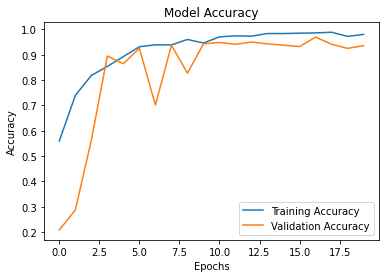

In [ ]:
#plotting the performance metrics
import matplotlib.pyplot as plt

plt.subplot(111)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.plot(hist1.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label = 'Validation Accuracy')

plt.legend()
plt.show()

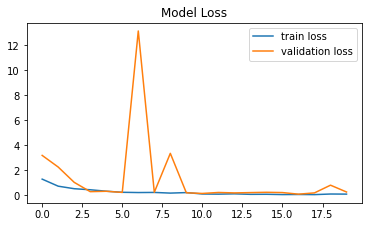

In [ ]:
plt.subplots_adjust(top=1.5)
plt.subplot(211)
plt.title('Model Loss')
plt.plot(hist1.history['loss'], label='train loss')
plt.plot(hist1.history['val_loss'], label='validation loss')
plt.legend()

# **Testing Accuracy on Model 1**

In [ ]:
#Using unseen data to test the model
preds = model1.evaluate(x_test, y_test)
print("Loss = " + str(preds[0]))
print("Testing Accuracy of Model 1 is " + str(preds[1]))

44/44 [==============================] - 3s 60ms/step - loss: 0.1995 - accuracy: 0.9452
Loss = 0.19945448637008667
Testing Accuracy of Model 1 is 0.945195734500885


# **Confusion Matrix and Classification metrics of Model 1**


In [ ]:
pred1 = model1.predict(x_test)
pred1 = np.argmax(pred1, axis = 1)

y_test_new_model_1 = np.argmax(y_test, axis=1)


44/44 [==============================] - 4s 56ms/step


In [ ]:
# print the text report showing the main classification metrics.

print(classification_report(y_test_new_model_1, pred1))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       348
           1       0.98      0.99      0.98       398
           2       0.95      0.86      0.90       342
           3       0.93      0.97      0.95       317

    accuracy                           0.95      1405
   macro avg       0.94      0.94      0.94      1405
weighted avg       0.95      0.95      0.94      1405



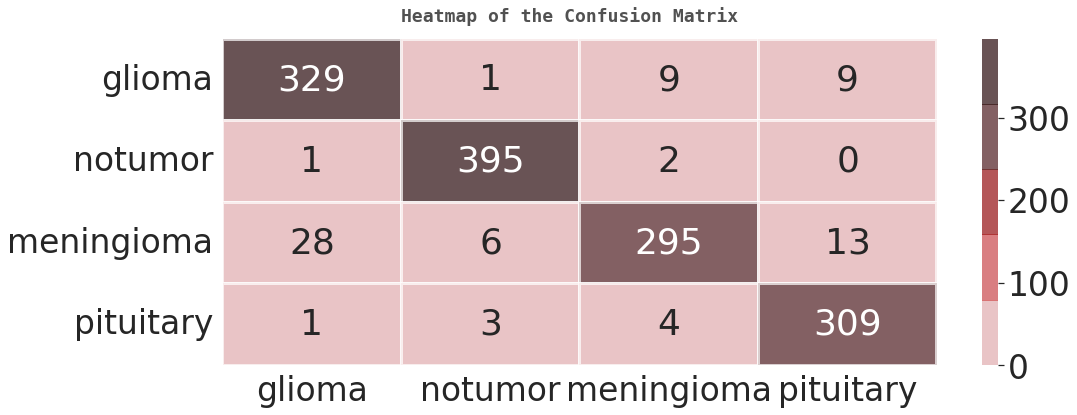

In [ ]:
# plotting the confusion matrix (Model 1)
fig,ax=plt.subplots(1,1,figsize=(16,6))
sns.set(font_scale=3.0)
sns.heatmap(confusion_matrix(y_test_new_model_1,pred1),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_red[::-1],alpha=0.7,linewidths=2, fmt = 'g')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

# **EfficientNet-B0 Implementation : Model 2 (Tuning)**

In [ ]:
efficient_net2 = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3 )) 

#utilize the weights trained on Imagenet on this model
#include_top parameter set to false so that the network doesn't include the top layers/output layer
#this allows us to add our own output layer 


In [ ]:
# designing the model architecture
model2 = efficient_net2.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation = 'softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficient_net2.input, outputs = model2)

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
#show the total number of layers in model 2 
print(len(model2.layers))

241


In [ ]:
from keras.optimizers import Adam

# Defining the optimizer, early stopping and learning rate 

optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss in order to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode = 'min',
                           verbose=1, patience =10, restore_best_weights = True)

#reducing the learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode = 'min', patience=5 , factor = 0.5, min_lr= 1e-6, verbose =1)

#compiling the model
model2.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Training Model 2**

In [ ]:
hist2 = model2.fit(x_train, y_train, validation_split=0.1,
                   callbacks = [early_stop, rlrop] ,      # Pass callback to training
                   epochs = 40 , 
                   verbose = 1, 
                   batch_size = 64)

Epoch 1/40
79/79 [==============================] - 56s 593ms/step - loss: 0.5471 - accuracy: 0.7996 - val_loss: 0.4893 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 2/40
79/79 [==============================] - 45s 571ms/step - loss: 0.1648 - accuracy: 0.9460 - val_loss: 0.2805 - val_accuracy: 0.9021 - lr: 1.0000e-04
Epoch 3/40
79/79 [==============================] - 45s 572ms/step - loss: 0.0810 - accuracy: 0.9733 - val_loss: 0.3617 - val_accuracy: 0.8915 - lr: 1.0000e-04
Epoch 4/40
79/79 [==============================] - 45s 571ms/step - loss: 0.0444 - accuracy: 0.9881 - val_loss: 0.3694 - val_accuracy: 0.8968 - lr: 1.0000e-04
Epoch 5/40
79/79 [==============================] - 45s 571ms/step - loss: 0.0325 - accuracy: 0.9893 - val_loss: 0.3060 - val_accuracy: 0.9146 - lr: 1.0000e-04
Epoch 6/40
79/79 [==============================] - 45s 573ms/step - loss: 0.0199 - accuracy: 0.9945 - val_loss: 0.2551 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 7/40
79/79 [======================

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model2.save('EfficientNetB0_Model_2_with_pretrained_weights_and_hyperparameters_tuned.h5') 

# **Evaluating Model 2**

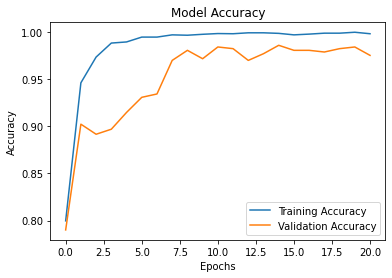

In [ ]:
#plot the performance metrics
import matplotlib.pyplot as plt

plt.subplot(111)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.plot(hist2.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label = 'Validation Accuracy')

plt.legend()
plt.show()

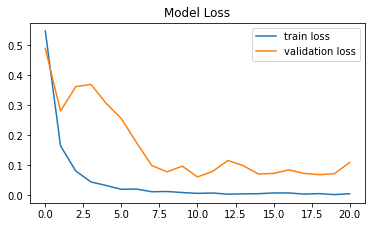

In [ ]:
plt.subplots_adjust(top=1.5)
plt.subplot(211)
plt.title('Model Loss')
plt.plot(hist2.history['loss'], label='train loss')
plt.plot(hist2.history['val_loss'], label='validation loss')
plt.legend()

# **Testing the accuracy of Model 2 on unseen data**

In [ ]:
#Using unseen data to test the model
preds = model2.evaluate(x_test, y_test)
print("Loss = " + str(preds[0]))
print("Testing Accuracy of Model 2 is " + str(preds[1]))

44/44 [==============================] - 3s 67ms/step - loss: 0.0196 - accuracy: 0.9943
Loss = 0.01958477310836315
Testing Accuracy of Model 2 is 0.9943060278892517


# **Confusion Matrix and Classification metrics of Model 2**


In [ ]:
pred2 = model2.predict(x_test)
pred2 = np.argmax(pred2, axis = 1)

y_test_new_model_2 = np.argmax(y_test, axis=1)

44/44 [==============================] - 4s 55ms/step


In [ ]:
# print the text report showing the main classification metrics.

print(classification_report(y_test_new_model_2, pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348
           1       0.99      1.00      1.00       398
           2       0.99      0.99      0.99       342
           3       0.99      0.99      0.99       317

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405



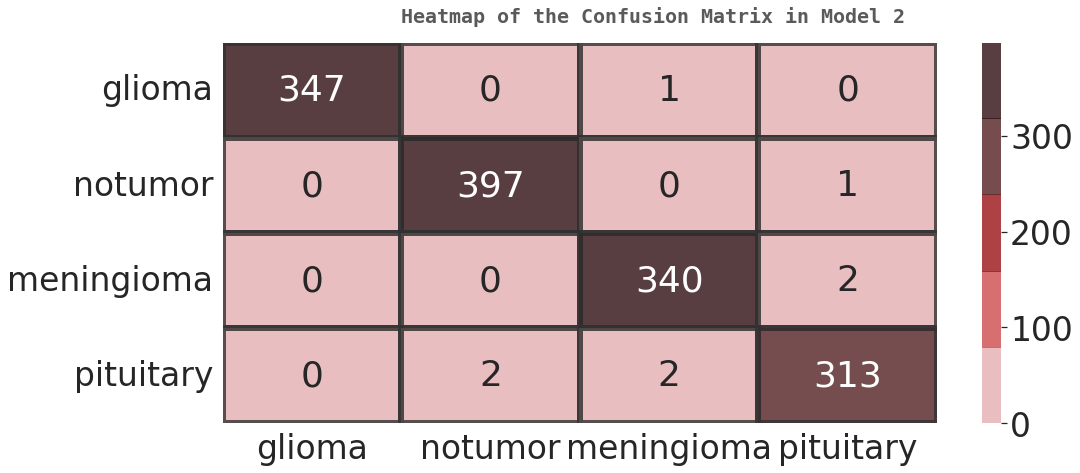

In [100]:
# plotting the confusion matrix (Model 2)
fig,ax=plt.subplots(1,1,figsize=(16,7))
sns.set(font_scale=3.0)
sns.heatmap(confusion_matrix(y_test_new_model_2,pred2),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_red[::-1],alpha=0.8,linewidths=5,linecolor='#313131', fmt= 'g')
fig.text(s='Heatmap of the Confusion Matrix in Model 2',size=20,fontweight='bold',
             fontname='monospace',color='#313131',y=0.92,x=0.28,alpha=0.8)

plt.show()